In [ ]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom
from stochastic.processes.continuous import FractionalBrownianMotion

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

In [75]:
N = 10
T = 200
L = None

WINDOW_WIDTHS = np.arange(10, 100, 2)
SHIFT_WIDTH = 40
JUMP_D = 5
NB_FEATURES = 2

In [ ]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [ ]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 / win_width
            xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 / win_width 
            ys2 = ys2 / win_width

            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.concatenate((np.ones(int(win_width/2)) * 0, vals))
        vals = np.concatenate((vals, np.ones(int(win_width/2)) * 0))
        vals = np.array(vals)
        all_vals.append(vals)
    
    all_vals = np.array(all_vals) + 1e-7
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return all_vals, normalized_vals

In [ ]:
def compress_signals(signals):
    compressed_signal = []
    nb_signal = signals.shape[1]
    
    for row in signals.transpose():
        nb_activ_window = np.sum(row >= 0)
        if nb_activ_window != 0:
            comp = np.sum(row[row >= 0]) / nb_activ_window
        else:
            comp = 1e-7
        compressed_signal.append(comp)
    compressed_signal = (np.array(compressed_signal) - float(np.min(compressed_signal))) / np.max(compressed_signal)
    return compressed_signal

In [ ]:
def slice_data(signal_seq, jump_d=10):
    slice_d = []
    indice = []
    for i in range(0, signal_seq.shape[1], jump_d):
        if i < SHIFT_WIDTH//2:
            tmp = signal_seq[:, max(0, i - SHIFT_WIDTH//2): i + SHIFT_WIDTH//2]
            crop = np.hstack((np.zeros((tmp.shape[0], SHIFT_WIDTH - tmp.shape[1])),tmp))
        elif i > signal_seq.shape[1] - SHIFT_WIDTH//2:
            tmp = signal_seq[:, i - SHIFT_WIDTH//2: min(signal_seq.shape[1], i + SHIFT_WIDTH//2)]
            crop = np.hstack((tmp, np.zeros((tmp.shape[0], SHIFT_WIDTH - tmp.shape[1]))))
        else:
            crop = signal_seq[:, i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice)

In [ ]:
def merge_close_points(changepoints, signal, seuil=5):
    seq_sums = []
    val_orders = np.argsort(signal[changepoints])[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [ ]:
def ana_cp_predict(model, x, y, win_widths, jump_d, check_proba=False):
    cps = []
    signal, norm_signal = make_signal(x, y, win_widths)
    input_signals, indice = slice_data(signal, jump_d=jump_d)

    input_signals = np.array(input_signals).reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(norm_signal, axis=1)**2 / np.std(norm_signal)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)
    
    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        #cps = indice[np.round(pred) >= 1]
        cps = indice[pred >= 0.5]

        if check_proba:
            for k, i in enumerate(range(0, x.shape[0], jump_d)):
                print(np.round(pred[k], 3), i, end='     ')
    if len(cps) == 0:
        return cps
        
    """
    reg_inputs = []
    for cp in cps:
        reg_inputs.append(signal_seq[:, cp - (SHIFT_WIDTH//2): cp + (SHIFT_WIDTH//2)])
    reg_inputs = np.array(reg_inputs).reshape(-1, activ_nb_win*2, SHIFT_WIDTH, 1)
    reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
    cps = np.round(cps + reg_outputs).astype(int)
    """
    #cps = merge_close_points(cps, comp_signal, seuil=5)

    return np.sort(cps)

In [ ]:
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
classification_model = tf.keras.models.load_model(f'./models/cls_model_{SHIFT_WIDTH}_2.keras')
#classification_model.summary()
#regression_model = tf.keras.models.load_model('regression_model_0.keras')
#regression_model.summary()

0.001 0     0.002 5     0.003 10     0.008 15     0.051 20     0.099 25     0.075 30     0.069 35     0.058 40     0.038 45     0.099 50     0.058 55     0.105 60     0.063 65     0.036 70     0.023 75     0.004 80     0.002 85     0.003 90     0.002 95     0.003 100     0.006 105     0.009 110     0.026 115     0.176 120     0.618 125     0.465 130     0.463 135     0.787 140     0.921 145     0.927 150     0.946 155     0.154 160     0.121 165     0.741 170     0.315 175     0.056 180     0.007 185     0.002 190     0.001 195     (200,)
[125 140 145 150 155 170]
SNR: [0.51177823 0.49847167 0.50367716 0.44975116 0.53039617 0.606663
 0.55486903 0.49445391 0.40785575 0.35341398 0.34211517 0.32167291
 0.31790656 0.29641552 0.31724911 0.31794709 0.31990364 0.3167087
 0.31798511 0.30881715 0.30174441 0.31651422 0.31372896 0.30787695
 0.32090589 0.32651685 0.36001949 0.4092836  0.45354536 0.48126238
 0.51513422 0.56708769 0.54589918 0.54343714 0.55138374 0.59991524
 0.61938814 0.62051575 0.

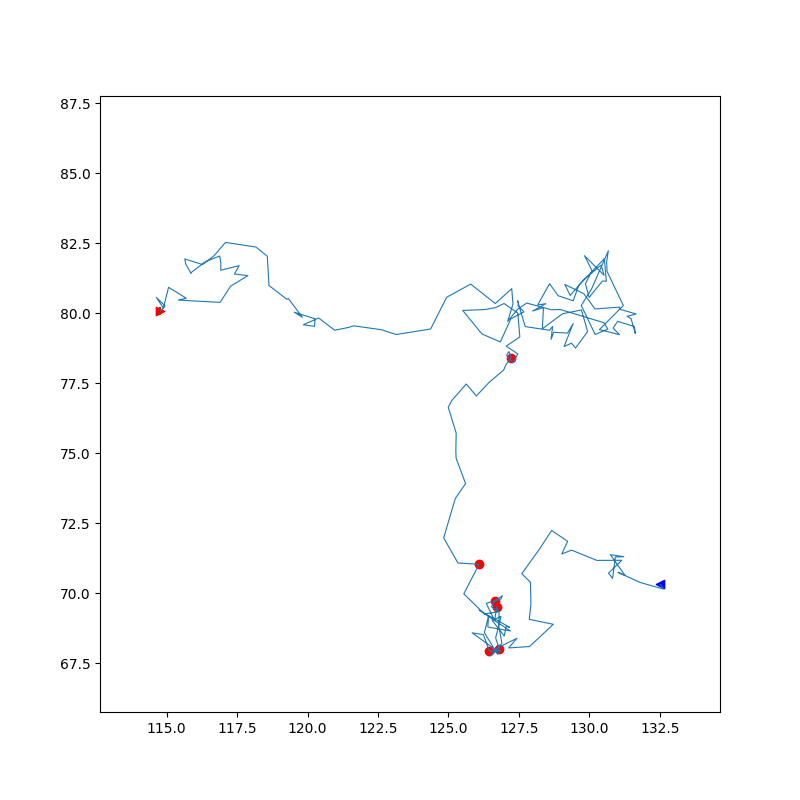

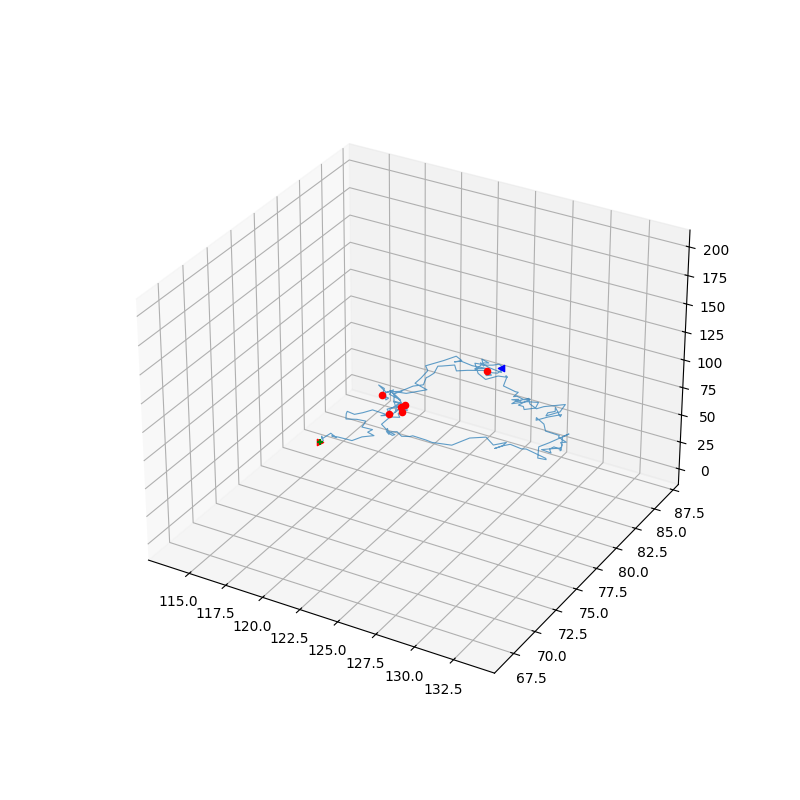

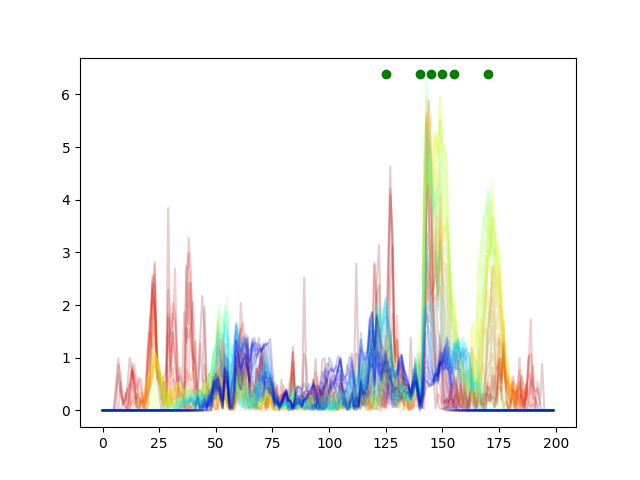

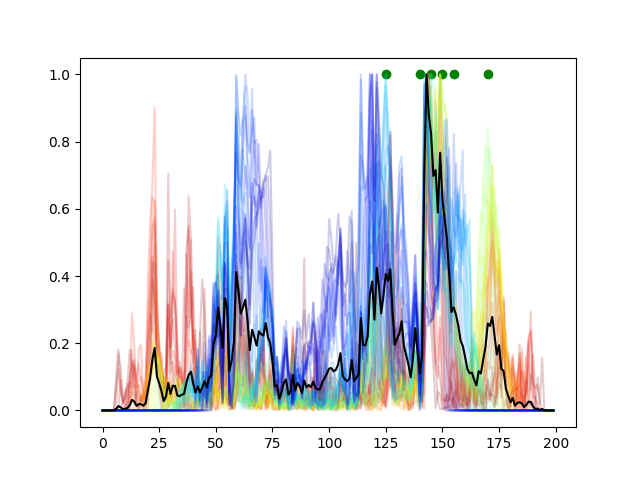

In [76]:
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

track = 2
exp = 11
fovs = [0]
traj_idx = [31] #25 check
checkpoints = [0]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')

    for idx in traj_idx:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]

        # Assign one changepoints for each traj at 0.25 of its length
        try:
            cps = ana_cp_predict(classification_model, x, y, WINDOW_WIDTHS, JUMP_D, True)
            #cps = np.concatenate((cps, [length_traj])).astype(int)
        except Exception as e:
            print(e)
            cps = []
            pass

        signals, norm_signals = make_signal(x, y, WINDOW_WIDTHS)
        print(x.shape)
        print(cps)
        plt.figure(figsize=(8, 8))
        plt.plot(x, y, linewidth=0.8)
        plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        for checkpoint in checkpoints:
            plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
        plt.scatter(x[0], y[0], marker='>', c='red')
        plt.scatter(x[-1], y[-1], marker='<', c='blue')
        
        for cp in cps:
            plt.scatter(x[cp], y[cp], c='red')
        plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
        for cp in cps:
            ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], c='red')

        ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
        ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')
        for checkpoint in checkpoints:
            ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

        plt.figure()
        for i in range(signals.shape[0]):
            plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.2,
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])
        plt.scatter(cps, np.array([np.max(signals)] * len(cps)), c='green')
        #plt.ylim([0, 10])
        
        plt.figure()
        for i in range(norm_signals.shape[0]):
            plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.2, 
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])
        comp_signal = compress_signals(norm_signals)
        feat1 = np.mean(norm_signals, axis=1)**2 / np.std(norm_signals, axis=1)**2
        feat2 = np.max(signals, axis=1).mean()
        print(f'SNR: {feat1}')
        print(f'Maxs_mean: {feat2}')
        #plt.plot(np.arange(signals.shape[1]), comp_signal / SNR / np.max(comp_signal / SNR), c='red')
        plt.plot(np.arange(signals.shape[1]), comp_signal, c='black')
        plt.scatter(cps, np.array([np.max(comp_signal)] * len(cps)), c='green')


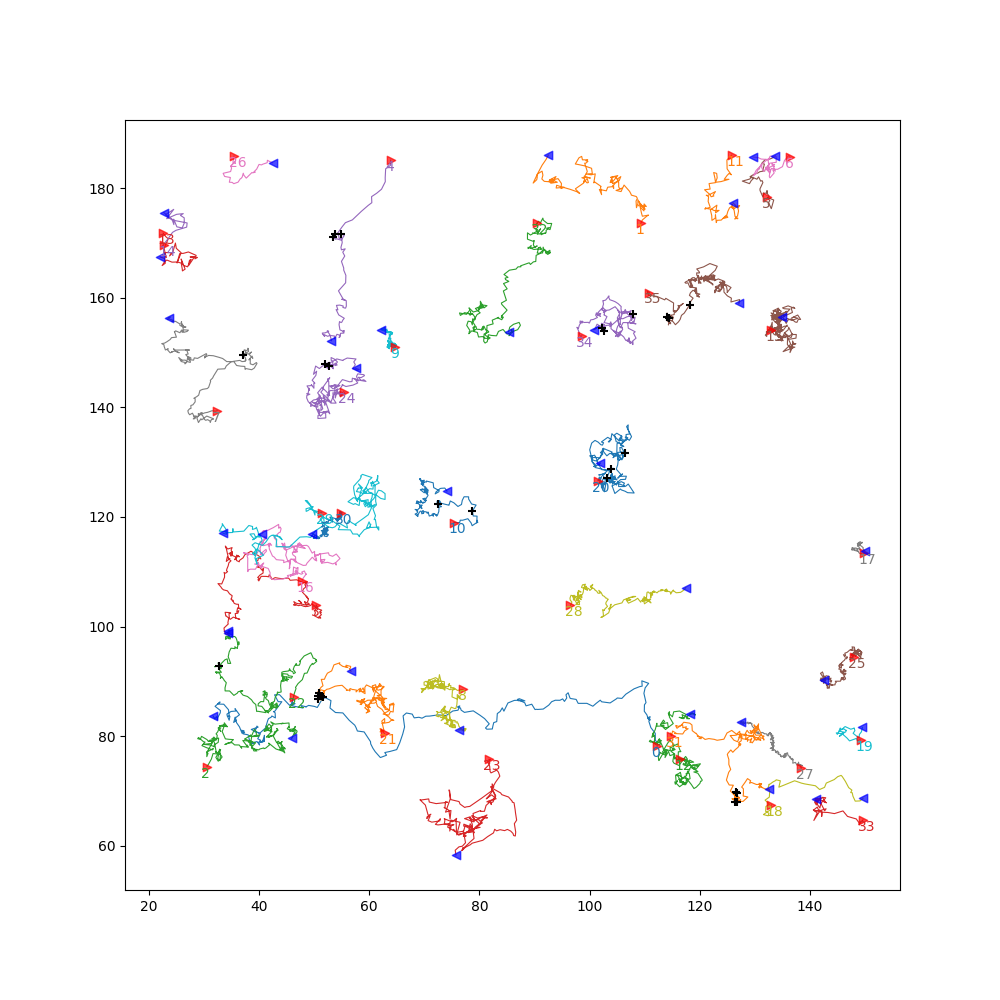

In [73]:
track = 2
exp = 11
fovs = [0]
check_indice = [0, 99]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
    plt.figure(figsize=(10, 10))
    for idx in np.unique(df.traj_idx).astype(int)[check_indice[0]: check_indice[1]]:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]
        cps = ana_cp_predict(classification_model, x, y, WINDOW_WIDTHS, JUMP_D)
        #print(f'{idx}, [{x[0]}, {y[0]}], [{x[-1]}, {y[-1]}]')

        trajectory = plt.plot(x, y, linewidth=0.8, zorder=0)
        plt.scatter(x[0], y[0], marker='>', c='red', zorder=1, alpha=0.7)
        plt.annotate(str(idx), xy=(x[0]-1,y[0]-2), color=trajectory[0].get_color())
        plt.scatter(x[-1], y[-1], marker='<', c='blue', zorder=1, alpha=0.7)
        for cp in cps:
            plt.scatter(x[cp], y[cp], marker='+', c='black', zorder=2) 


# Produce a trajectory and check signals

In [ ]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.2, 1.3],
                                                        Ds=[[0.05, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
signal_seq = make_signal(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS, SEARCH_WIDTH)
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
print(changepoints)

%matplotlib widget
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

track = 2
exp = 0
fovs = [0]
traj_idx = [0]
checkpoint = 0
        
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]

signals, norm_signals = make_signal(x, y, WINDOW_WIDTHS, SEARCH_WIDTH)
plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')
ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

plt.figure()
for i in range(signals.shape[0]):
    plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.3,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])

        
plt.figure()
for i in range(norm_signals.shape[0]):
    plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.3,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])
comp_signal = compress_signals(signals)
SNR = np.mean(comp_signal)**2 / np.std(comp_signal)**2
print(f'SNR: {SNR}')
print(f'Max_val signals: {np.max(signals, axis=1).mean()}')
plt.plot(np.arange(signals.shape[1]), comp_signal / SNR / np.max(comp_signal / SNR), c='red')

for cp in changepoints:
    plt.vlines(cp, 0, 1, color='black')
#plt.ylim([-0.1, 1.1])
